In [100]:
import fbprophet
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [101]:
import math
def rmse_metric(actual, predicted):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return math.sqrt(mean_error)

In [57]:
df = pd.read_csv('master1.csv',parse_dates=[0]).set_index('Date')
df.head(2)

,Total_Bed_Capacity,Total_Beds_Occupancy,DCH & DCHC_ Bed_Capacity,DCH & DCHC_ Beds_Occupancy,CCC2_Active_Bed_Capacity,CCC2_Active_Bed_Occupancy,ICU_Bed_Capacity,ICU_Beds_Occupancy,O2_Bed_Capacity,O2_Beds_Occupancy,Ventilator_Bed_Capacity,Ventilator_Beds_Occupancy,non_ICU_Bed_Capacity,Total_positive_tests,Total_tests,Stable_Symptomatic,Critical
Date,,,,,,,,,,,,,,,,,
2020-06-07,17936.0,13739.0,10531.0,9227.0,7405.0,4512.0,1157.0,1141.0,5114.0,3760.0,476.0,446.0,3957.0,1385.0,4954.0,NaN,NaN
2020-06-08,18110.0,13759.0,10702.0,9278.0,7408.0,4481.0,1164.0,1154.0,5946.0,4532.0,493.0,471.0,4782.0,1294.0,3671.0,6769.0,916.0


In [102]:
def predict_occupancy(df,predict_var):
  train = df[[str(predict_var),'Total_positive_tests','Stable_Symptomatic']][:'2021-03'].interpolate().bfill().reset_index()
  train.columns = ['ds','y','Total_positive_tests','Stable_Symptomatic']
  train['ds'] = pd.to_datetime(train['ds'])
  
  model = fbprophet.Prophet(interval_width=0.95,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)
  model.add_regressor('Total_positive_tests')
  model.add_regressor('Stable_Symptomatic')
  #model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(train)
  #model.component_modes
  future_dates = model.make_future_dataframe(periods=127)

  future_dates['Total_positive_tests'] = df['Total_positive_tests'].interpolate()[train['ds'][0]:(train['ds'][-1:]+datetime.timedelta(days=127)).to_list()[0]].to_list() 
  future_dates['Stable_Symptomatic'] = df['Stable_Symptomatic'].interpolate()[train['ds'][0]:(train['ds'][-1:]+datetime.timedelta(days=127)).to_list()[0]].to_list() 
  try:
    future_dates = future_dates.bfill()
  except:
    future_dates = future_dates.ffill()
  
  forecast = model.predict(future_dates)
  

  f = pd.merge(df[[str(predict_var)]].dropna().reset_index(),forecast,left_on='Date',right_on='ds',how='outer').dropna().drop('ds',axis=1).set_index('Date')

  return f

In [142]:
predict_var = input('''What metric do you want to predict? \n
a) Total_Beds_Occupancy \n
b) O2_Beds_Occupancy \n
c) ICU_Beds_Occupancy \n
d) Ventilator_Beds_Occupancy \n''')

if predict_var == 'a':
  predict_var = 'Total_Beds_Occupancy'
elif predict_var =='b':
  predict_var = 'O2_Beds_Occupancy'
elif predict_var =='c':
  predict_var = 'ICU_Beds_Occupancy'
elif predict_var =='d':
  predict_var = 'Ventilator_Beds_Occupancy'
else:
  print('Please choose correct option')

What metric do you want to predict? 

a) Total_Beds_Occupancy 

b) O2_Beds_Occupancy 

c) ICU_Beds_Occupancy 

d) Ventilator_Beds_Occupancy 
a


In [143]:
rmses = []
shifts = []


for i in range(-14,15,1):
  df = pd.read_csv('master1.csv',parse_dates=[0]).set_index('Date')
  df.Total_positive_tests = df.Total_positive_tests.shift(i)
  df.Stable_Symptomatic = df.Stable_Symptomatic.shift(i)
  f = predict_occupancy(df,predict_var)
  #f.yhat = f.yhat.rolling(7).mean()

  actual = f['2021-04':][predict_var].to_list()
  predicted = f['2021-04':].yhat.to_list()

  rmses.append(rmse_metric(actual, predicted))
  shifts.append(i)

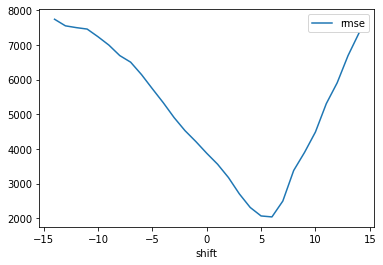

In [144]:
rmse_df = pd.DataFrame([shifts,rmses]).T
rmse_df.columns=['shift','rmse']
rmse_df = rmse_df.set_index('shift')
rmse_df.plot()

In [145]:
df = pd.read_csv('/content/drive/MyDrive/master1.csv',parse_dates=[0]).set_index('Date')
df.Total_positive_tests = df.Total_positive_tests.shift(int(rmse_df.rmse.idxmin()))
df.Stable_Symptomatic = df.Stable_Symptomatic.shift(int(rmse_df.rmse.idxmin()))
f = predict_occupancy(df,predict_var)
#f.yhat = f.yhat.rolling(7).mean()

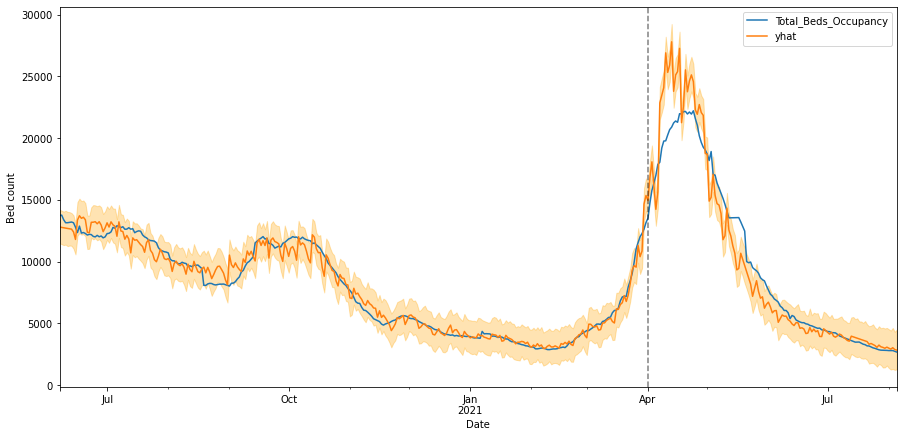

In [146]:
fig, ax = plt.subplots(figsize=(15,7))
f[[str(predict_var),'yhat']].plot(ax=ax)
ax.fill_between(f.index, f.yhat_lower, f.yhat_upper, color='orange', alpha=.3)
ax.axvline(x='2021-04-01',color='black',linestyle='--', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Bed count')

plt.show()